In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import scikitplot

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from modules import f1_metric

### **Read test data**

In [3]:
df = pd.read_csv("E:/vindr_mammo/Data/full_df.csv")
df['image_path'] = 'E:/vindr_mammo/Data/png/' + df['study_id'] + '/' + df['image_id'] + '.png'
df['label'] = df['breast_birads'].map({'BI-RADS 1': '0',
                                       'BI-RADS 2': '0',
                                       'BI-RADS 3': '1',
                                       'BI-RADS 4': '1',
                                       'BI-RADS 5': '1'})
train_df = df[df['split'] == 'training']
tmp_test_df = df[df['split'] == 'test']
test_df, val_df = train_test_split(tmp_test_df, test_size=0.5, stratify=tmp_test_df['label'], random_state=42)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

ts_gen = ImageDataGenerator()
test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'image_path', y_col= 'label', target_size=(224, 224), class_mode= 'categorical',
                                        color_mode='rgb', shuffle= False, batch_size= test_batch_size)


Found 2000 validated image filenames belonging to 2 classes.


### **Load model weight**

In [4]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,
                                                               weights="imagenet",
                                                               input_shape=img_shape, pooling='max')


model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512, kernel_regularizer=regularizers.l2(l= 0.016),
               activity_regularizer=regularizers.l1(0.006),
               bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.5, seed= 123),
    Dense(2, activation= 'softmax')])

model.load_weights('./output/best/model_weights.h5')

model.compile(Adamax(learning_rate= 0.001),
              loss='categorical_crossentropy',
              metrics= [tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
                        f1_metric.F1Score(),
                        'accuracy'])

In [5]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

25/25 [==============================] - 68s 3s/step
[1 0 1 ... 1 0 1]


In [6]:
# Save model predictions to CSV
y_true = test_gen.classes

# Get filenames from the test generator
filenames = test_gen.filenames

# Assuming y_pred is the predicted class (use argmax to get class labels)
y_pred_class = y_pred

# Create a DataFrame with predictions, true labels, and predicted probabilities for each class
results = pd.DataFrame({
    "img_path": filenames,
    "true_class": y_true,
    "predicted_class": y_pred_class,
    "prob_class_0": preds[:, 0],  # Probability for class 0
    "prob_class_1": preds[:, 1]   # Probability for class 1
})

# Save the DataFrame to a CSV file
results.to_csv("./output/best/prediction_result.csv", index=False)
results

,img_path,true_class,predicted_class,prob_class_0,prob_class_1
0,E:/vindr_mammo/Data/png/b2979c0f7fa4edae4a174b...,1,1,0.097039,0.902961
1,E:/vindr_mammo/Data/png/d0322ac75743dc7de6f530...,0,0,0.560399,0.439601
2,E:/vindr_mammo/Data/png/1fe77db1e47d9133c2bc79...,0,1,0.432204,0.567796
3,E:/vindr_mammo/Data/png/2db80265d2be0198a5840d...,0,0,0.501322,0.498678
4,E:/vindr_mammo/Data/png/d90bbc67c79e9aac98f848...,0,0,0.653458,0.346542
...,...,...,...,...,...
1995,E:/vindr_mammo/Data/png/4f2dbafc344f1427addc52...,0,0,0.570105,0.429895
1996,E:/vindr_mammo/Data/png/9b7e001b3af23c0daddccb...,0,0,0.972225,0.027775
1997,E:/vindr_mammo/Data/png/fbc135926b71e4f85482ba...,0,1,0.490424,0.509576
1998,E:/vindr_mammo/Data/png/80c50f0adee98ec46aca1f...,0,0,0.573937,0.426063


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("F1 Score: {}".format(f1_score(y_true,y_pred)))
print("Recall score: {}".format(recall_score(y_true,y_pred)))
print("Precision score: {}".format(precision_score(y_true,y_pred)))

# Extract values from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate Sensitivity and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print the results
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")

F1 Score: 0.26346153846153847
Recall score: 0.7135416666666666
Precision score: 0.1615566037735849
Sensitivity (True Positive Rate): 0.7135
Specificity (True Negative Rate): 0.6067


              precision    recall  f1-score   support

           0       0.95      0.61      0.74      1808
           1       0.16      0.71      0.26       192

    accuracy                           0.62      2000
   macro avg       0.56      0.66      0.50      2000
weighted avg       0.88      0.62      0.70      2000



<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

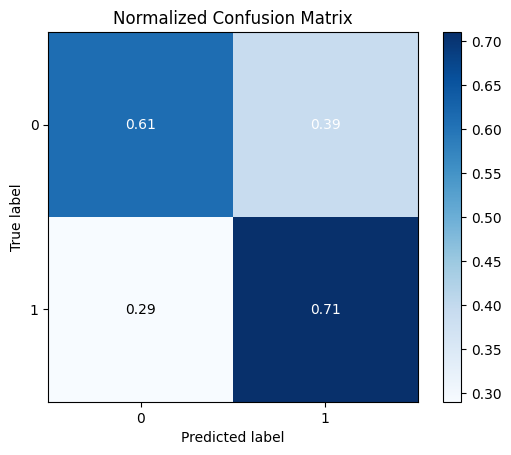

In [8]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))
scikitplot.metrics.plot_confusion_matrix(y_true, y_pred, normalize=True)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

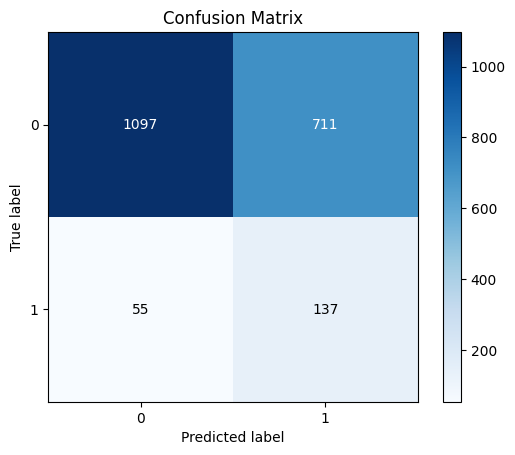

In [9]:
scikitplot.metrics.plot_confusion_matrix(y_true, y_pred, normalize=False)

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

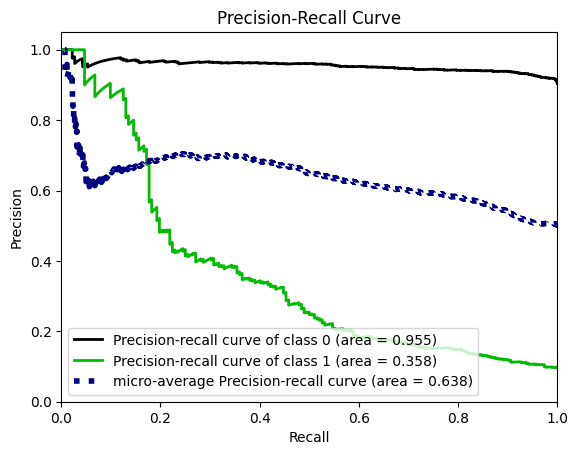

In [10]:
scikitplot.metrics.plot_precision_recall(y_true, preds)